## Elasticity 2D multiple network for plane stress with 7 layered NN with defined body forces

Epoch 0, Loss: 2075.11669921875
Epoch 50, Loss: 885.2033081054688
Epoch 100, Loss: 287.8510437011719
Epoch 150, Loss: 34.76750564575195
Epoch 200, Loss: 10.964290618896484
Epoch 250, Loss: 6.177272796630859
Epoch 300, Loss: 4.201656341552734
Epoch 350, Loss: 2.75919246673584
Epoch 400, Loss: 2.092442512512207
Epoch 450, Loss: 1.6805493831634521


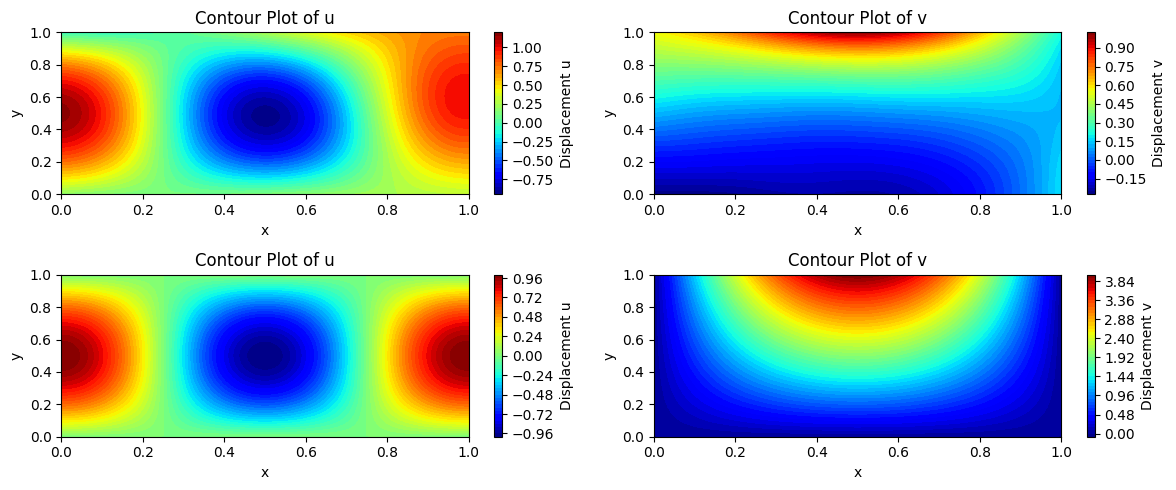

In [1]:
# Elasticity2DmultipleNetwork.ipynb

import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

lamb = 1
mu= 0.5
lamb2mu=lamb+2*mu
Q=4

# Define the Neural Network for solving the PDE

class SimplePINN(tf.keras.Model):
    def __init__(self, layer_sizes):
        super(SimplePINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(size, activation='tanh') for size in layer_sizes[:-1]]
        self.output_layer = tf.keras.layers.Dense(layer_sizes[-1])

    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

def stiffness_matrix(lamb, mu, case="plane_strain"):

    # Compute the stiffness matrix for plane stress and plane strain conditions.
    # Parameters:
    #     E (float): Young's modulus
    #     nu (float): Poisson's ratio
    #     case (str): "plane_stress" or "plane_strain"
    # Returns:
    #     tf.Tensor: 3x3 stiffness matrix

    lamb = tf.convert_to_tensor(lamb, dtype=tf.float32)
    mu = tf.convert_to_tensor(mu, dtype=tf.float32)
    if case == "plane_stress":
        # C11 = lamb / (1 - nu**2)
        # C12 = nu * C11
        # C66 = E / (2 * (1 + nu))
        raise ValueError("Invalid case: Choose 'plane_stress' or 'plane_strain'")
    elif case == "plane_strain":
        C11 = lamb+2*mu
        C12 = lamb
        C66 = mu
    else:
        raise ValueError("Invalid case: Choose 'plane_stress' or 'plane_strain'")
    C = tf.stack([
        [C11, C12, 0],
        [C12, C11, 0],
        [0, 0, C66]
    ])
    return C


def body_force_fn(points, lamb, mu, Q):
    x=points[:,0:1]
    y=points[:,1:2]

    f0 = lamb * (4 * np.pi ** 2 * tf.cos(2 * np.pi * x) * tf.sin(np.pi * y) - np.pi * tf.cos(np.pi * x) * Q * y**3) + mu * (9 * np.pi ** 2 * tf.cos(2 * np.pi * x) * tf.sin(np.pi * y)- np.pi * tf.cos(np.pi * x) * Q * y ** 3)

    f1 = lamb * (-3 * tf.sin(np.pi * x) * Q * y**2 + 2 * (np.pi**2) * tf.sin(2 * np.pi * x) * tf.cos(np.pi * y)) + mu * (-6 * tf.sin(np.pi * x) * Q * y**2 + 2 * (np.pi**2) * tf.sin(2 * np.pi * x) * tf.cos(np.pi * y)+ ((np.pi**2) * tf.sin(np.pi * x) * Q * y**4) / 4)

    return tf.stack(tf.stack([tf.reshape(f0,[-1]), tf.reshape(f1,[-1])],axis=1))
    # return tf.stack(tf.stack([tf.reshape(f0,[-1]), tf.reshape(f1,[-1])],axis=1)) # Dedented this line by one level
    # return tf.stack([tf.reshape(f0, [-1]), tf.reshape(f1, [-1])], axis=1)


# Function to compute PDE residual
def compute_pde_residual(model, points, StiffMat, lamb, mu, Q, body_force_fn):
    with tf.GradientTape(persistent=True) as outer_tape:
        outer_tape.watch(points)
        with tf.GradientTape(persistent=True) as inner_tape:
            inner_tape.watch(points)
            predicted_uv = model(points)
            predicted_u=predicted_uv[:,0:1]
            predicted_v=predicted_uv[:,1:2]
        grad_u = inner_tape.gradient(predicted_u, points)
        grad_v = inner_tape.gradient(predicted_v, points)
        Sxx = StiffMat[0,0] * grad_u[:,0:1] + StiffMat[0,1] * grad_v[:,1:2]
        Syy = StiffMat[1,0] * grad_u[:,0:1] + StiffMat[1,1] * grad_v[:,1:2]
        Sxy = StiffMat[2,2] * (grad_u[:,1:2] + grad_v[:,0:1])
    Sxx_x = outer_tape.gradient(Sxx, points)[:,0]
    Syy_y = outer_tape.gradient(Syy, points)[:,1]
    grad_Sxy = outer_tape.gradient(Sxy, points)
    Sxy_x = grad_Sxy[:,0]
    Sxy_y = grad_Sxy[:,1]
    del inner_tape, outer_tape
    body_force = body_force_fn(points, lamb, mu, Q)
    residue = tf.stack([Sxx_x + Sxy_y + body_force[:,0], Sxy_x + Syy_y + body_force[:,1]], axis=1)
    return residue

# Total loss function
def compute_total_loss(model, points, left, right, bottom, top, StiffMat, lamb, mu, Q, body_force_fn):
    residue = compute_pde_residual(model, points, StiffMat, lamb, mu, Q, body_force_fn)
    pde_loss = tf.reduce_mean(tf.square(residue[:,0:1])) + tf.reduce_mean(tf.square(residue[:,1:2]))

    with tf.GradientTape(persistent=True) as inner_tape:
      inner_tape.watch(left)
      predicted_uv = model(left)
      predicted_u=predicted_uv[:,0:1]
      predicted_v=predicted_uv[:,1:2]
    grad_u = inner_tape.gradient(predicted_u, left)
    grad_v = inner_tape.gradient(predicted_v, left)
    del inner_tape
    Sxx = StiffMat[0,0] * grad_u[:,0:1] + StiffMat[0,1] * grad_v[:,1:2]
    left_boundary_loss = tf.reduce_mean(tf.square(predicted_v))+tf.reduce_mean(tf.square(Sxx))

    with tf.GradientTape(persistent=True) as inner_tape:
      inner_tape.watch(right)
      predicted_uv = model(right)
      predicted_u=predicted_uv[:,0:1]
      predicted_v=predicted_uv[:,1:2]
    grad_u = inner_tape.gradient(predicted_u, right)
    grad_v = inner_tape.gradient(predicted_v, right)
    del inner_tape
    Sxx = StiffMat[0,0] * grad_u[:,0:1] + StiffMat[0,1] * grad_v[:,1:2]
    right_boundary_loss = tf.reduce_mean(tf.square(predicted_v))+tf.reduce_mean(tf.square(Sxx))

    bottom_boundary_loss = tf.reduce_mean(tf.square(model(bottom)[:,0:1]))+tf.reduce_mean(tf.square(model(bottom)[:,1:2]))

    with tf.GradientTape(persistent=True) as inner_tape:
      inner_tape.watch(top)
      predicted_uv = model(top)
      predicted_u=predicted_uv[:,0:1]
      predicted_v=predicted_uv[:,1:2]
    grad_u = inner_tape.gradient(predicted_u, top)
    grad_v = inner_tape.gradient(predicted_v, top)
    del inner_tape
    Syy = StiffMat[1,0] * grad_u[:,0:1] + StiffMat[1,1] * grad_v[:,1:2]
    top_boundary_loss = tf.reduce_mean(tf.square(predicted_u))+tf.reduce_mean(tf.square(Syy-(lamb+2*mu)*Q*tf.sin(np.pi*top[:,0:1])))

    return pde_loss + left_boundary_loss + right_boundary_loss + top_boundary_loss + bottom_boundary_loss



# Problem setup
num_collocation_points = 50
x_points, y_points = tf.meshgrid(tf.linspace(0.0, 1.0, num_collocation_points), tf.linspace(0.0, 1.0, num_collocation_points), indexing="ij")
points=tf.stack([tf.reshape(x_points, [-1]), tf.reshape(y_points, [-1])], axis=1)

x_left, y_left = tf.meshgrid(tf.linspace(0.0, 0.0, 1), tf.linspace(0.0, 1.0, num_collocation_points), indexing="ij")
left=tf.stack([tf.reshape(x_left, [-1]), tf.reshape(y_left, [-1])], axis=1)

x_right, y_right = tf.meshgrid(tf.linspace(1.0, 1.0, 1), tf.linspace(0.0, 1.0, num_collocation_points), indexing="ij")
right=tf.stack([tf.reshape(x_right, [-1]), tf.reshape(y_right, [-1])], axis=1)

x_top, y_top = tf.meshgrid(tf.linspace(0.0, 1.0, num_collocation_points), tf.linspace(1.0, 1.0, 1), indexing="ij")
top=tf.stack([tf.reshape(x_top, [-1]), tf.reshape(y_top, [-1])], axis=1)

x_bottom, y_bottom = tf.meshgrid(tf.linspace(0.0, 1.0, num_collocation_points), tf.linspace(0.0, 0.0, 1), indexing="ij")
bottom=tf.stack([tf.reshape(x_bottom, [-1]), tf.reshape(y_bottom, [-1])], axis=1)

# lamb = 1
# mu= 0.5
# lamb2mu=lamb+2*mu
# Q=4
case2D="plane_strain"


layer_sizes = [50, 50, 50, 50, 50, 2]
StiffMat=stiffness_matrix(lamb, mu, case2D)
model = SimplePINN(layer_sizes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
num_epochs = 500
tolerance = 1e-6
previous_loss = float('inf')
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss = compute_total_loss(model, points, left, right, bottom, top, StiffMat, lamb, mu, Q, body_force_fn)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")
        if abs(previous_loss - loss.numpy()) < tolerance:
            print(f"Converged at epoch {epoch}, Loss: {loss.numpy()}")
            break
        previous_loss = loss.numpy()

# Predictions and analytical solution
num_collocation_points = 100
x_points, y_points = tf.meshgrid(tf.linspace(0.0, 1.0, num_collocation_points), tf.linspace(0.0, 1.0, num_collocation_points), indexing="ij")
test_points=tf.stack([tf.reshape(x_points, [-1]), tf.reshape(y_points, [-1])], axis=1)

predicted_uv = model(test_points)
analy_u = tf.cos(2*np.pi*test_points[:,0:1])*tf.sin(np.pi*test_points[:,1:2])
analy_v = tf.sin(np.pi*test_points[:,0:1])*Q*test_points[:,1:2]*4/4

predicted_u = tf.reshape(predicted_uv[:,0:1], (num_collocation_points, num_collocation_points)).numpy()
predicted_v = tf.reshape(predicted_uv[:,1:2], (num_collocation_points, num_collocation_points)).numpy()
analy_u = tf.reshape(analy_u, (num_collocation_points, num_collocation_points)).numpy()
analy_v = tf.reshape(analy_v, (num_collocation_points, num_collocation_points)).numpy()

# Convert grid points to NumPy for plotting
x_points = x_points.numpy()
y_points = y_points.numpy()

# Plot contour for u
plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
plt.contourf(x_points, y_points, predicted_u, levels=50, cmap="jet")
plt.colorbar(label="Displacement u")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Contour Plot of u")

# Plot contour for v
plt.subplot(2, 2, 2)
plt.contourf(x_points, y_points, predicted_v, levels=50, cmap="jet")
plt.colorbar(label="Displacement v")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Contour Plot of v")

# Plot contour for u

plt.subplot(2, 2, 3)
plt.contourf(x_points, y_points, analy_u, levels=50, cmap="jet")
plt.colorbar(label="Displacement u")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Contour Plot of u")

# Plot contour for v
plt.subplot(2, 2, 4)
plt.contourf(x_points, y_points, analy_v, levels=50, cmap="jet")
plt.colorbar(label="Displacement v")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Contour Plot of v")

plt.tight_layout()
plt.show()

